<a href="https://colab.research.google.com/github/thruuuuuu/telco_churn_predict_model/blob/main/notebooks/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imbalanced-learn shap


# Setup

In [56]:
import pandas as pd

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Display first few rows
data = pd.DataFrame(df)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Quick Exploration

In [57]:
df.head()
df.info()
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,6531,2
top,3186-AJIEK,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,...,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


# Indexing

In [6]:
df.iloc[:, 3]

,Partner
0,Yes
1,No
2,No
3,No
4,No
...,...
7038,Yes
7039,Yes
7040,Yes
7041,Yes


# Data Cleaning
*   Removing duplicates or irrelevent observations
*   Fixing structural errors
*   Filtering unwanted outliers
*   Handling missing data
*   Validation







In [58]:
import pandas as pd
import numpy as np

# Make a copy for cleaning
df_cleaned = df.copy()

# 1. Fix TotalCharges column
# Convert TotalCharges → numeric
df_cleaned['TotalCharges'] = pd.to_numeric(df_cleaned['TotalCharges'], errors='coerce')

# Fill NaN TotalCharges ( tenure = 0 cases )
df_cleaned['TotalCharges'] = df_cleaned['TotalCharges'].fillna(0)

# 2. Remove 'customerID' ONLY if it exists
if 'customerID' in df_cleaned.columns:
    df_cleaned = df_cleaned.drop(columns=['customerID'])

# 3. Remove duplicates
duplicate_count = df_cleaned.duplicated().sum()

if duplicate_count > 0:
    df_cleaned = df_cleaned.drop_duplicates(keep='first')

# 4. Summary dictionary (clean output)
cleaning_summary = {
    "Initial Shape": df.shape,
    "Final Shape": df_cleaned.shape,
    "Duplicates Removed": duplicate_count,
    "TotalCharges dtype": str(df_cleaned['TotalCharges'].dtype)
}

cleaning_summary


{'Initial Shape': (7043, 21),
 'Final Shape': (7021, 20),
 'Duplicates Removed': np.int64(22),
 'TotalCharges dtype': 'float64'}

Impute with missing values

In [59]:
# Impute missing values in categorical columns with the most frequent value (mode)
def impute_missing_values(df_cleaned):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    for column in categorical_columns:
        if df_cleaned[column].isnull().sum() > 0:
            mode_value = df_cleaned[column].mode()[0]  # Calculate the mode of the column
            df_cleaned[column].fillna(mode_value, inplace=True)

# Impute missing values in the dataset
impute_missing_values(data)

# Verify if all missing values are handled after imputation
missing_values_after = data.isnull().sum()
print("Columns with remaining missing values:")
print(missing_values_after[missing_values_after > 0])

Columns with remaining missing values:
Series([], dtype: int64)


Target Variable Distribution

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

churn_counts = df_cleaned['Churn'].value_counts()
churn_percent = df_cleaned['Churn'].value_counts(normalize=True) * 100

churn_counts
churn_percent

,proportion
Churn,
No,73.550776
Yes,26.449224


# EDA Distributions Visualization

Churn Statistics Visualization (Bar Chart, Pie Chart)

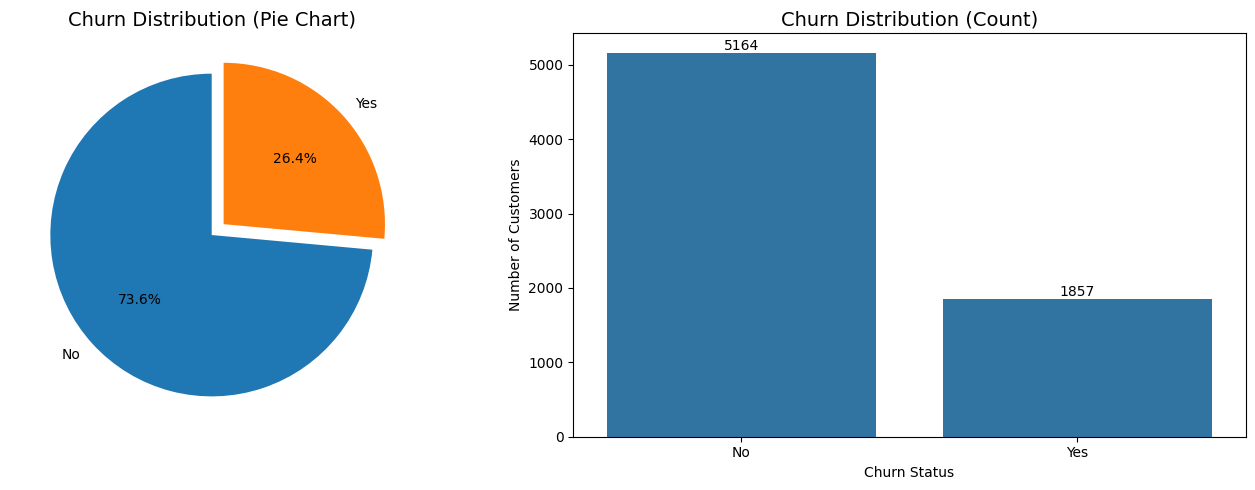

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#Pie chart
axes[0].pie(
    churn_counts,
    labels=churn_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    explode=(0, 0.1)
)
axes[0].set_title('Churn Distribution (Pie Chart)', fontsize=14)

# Bar chart
sns.countplot(data=df_cleaned, x='Churn', ax=axes[1])
axes[1].set_title('Churn Distribution (Count)', fontsize=14)
axes[1].set_xlabel('Churn Status')
axes[1].set_ylabel('Number of Customers')

# labels on bars
for container in axes[1].containers:
    axes[1].bar_label(container)

plt.tight_layout()
plt.show()


Visualize correlation (for numerical columns)

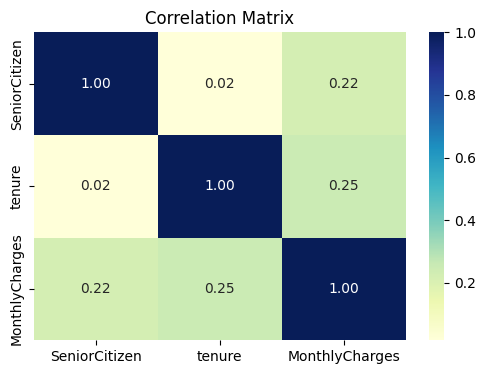

In [30]:
numerical_data = data.select_dtypes(include=['number'])

# Calculate correlation
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Correlation Matrix")
plt.show()

Histogram for Numerical Features

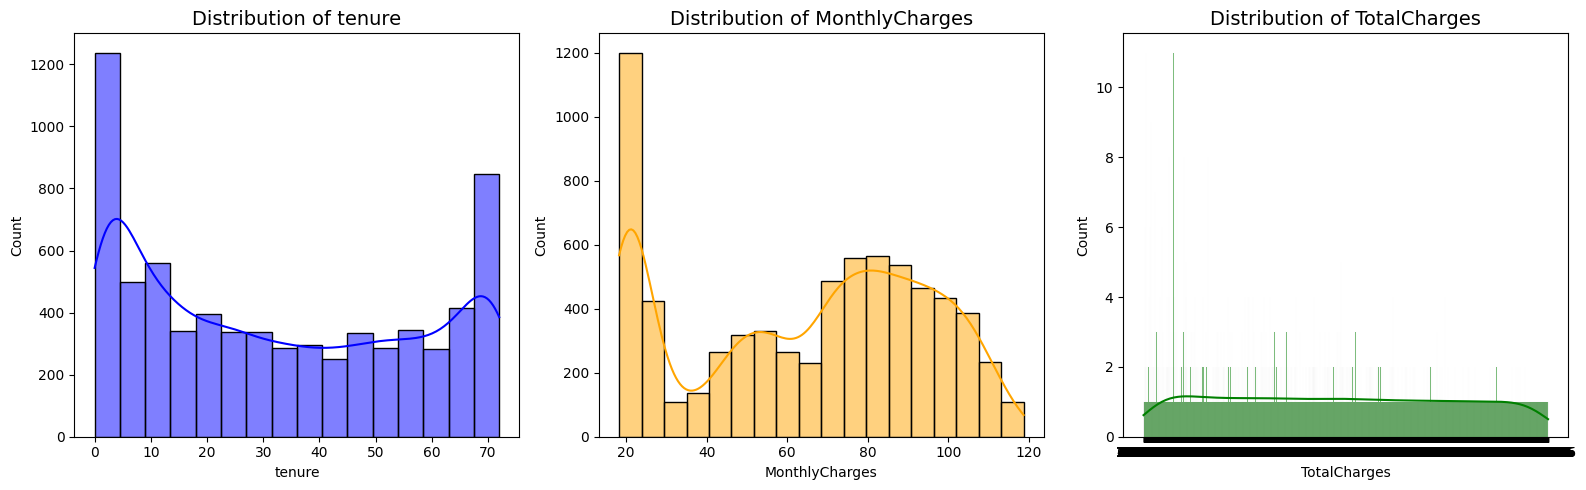

In [63]:

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Subplots for 3 features
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ['blue', 'orange', 'green']  # One color per feature

# Loop through numerical features
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color=colors[i])
    axes[i].set_title(f"Distribution of {col}", fontsize=14)

plt.tight_layout()
plt.show()


Box plots for Numerical Features

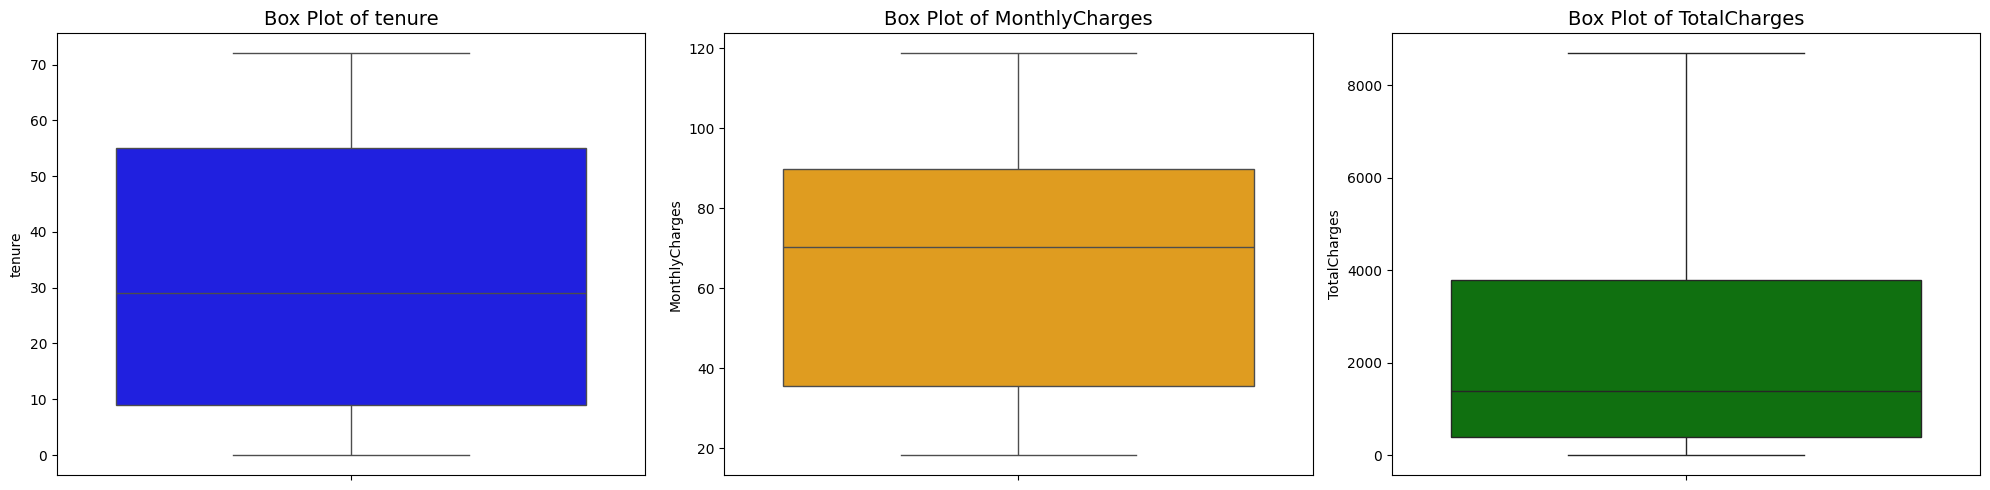

In [64]:

import math

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Subplots for 3 features
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
colors = ['blue', 'orange', 'green']  # One color per feature

# Loop through numerical features
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=numerical_data, y=col, ax=axes[i], color=colors[i % len(colors)])
    axes[i].set_title(f"Box Plot of {col}", fontsize=14)

plt.tight_layout()
plt.show()


Categorical Feature Bar Charts (Count Distribution)

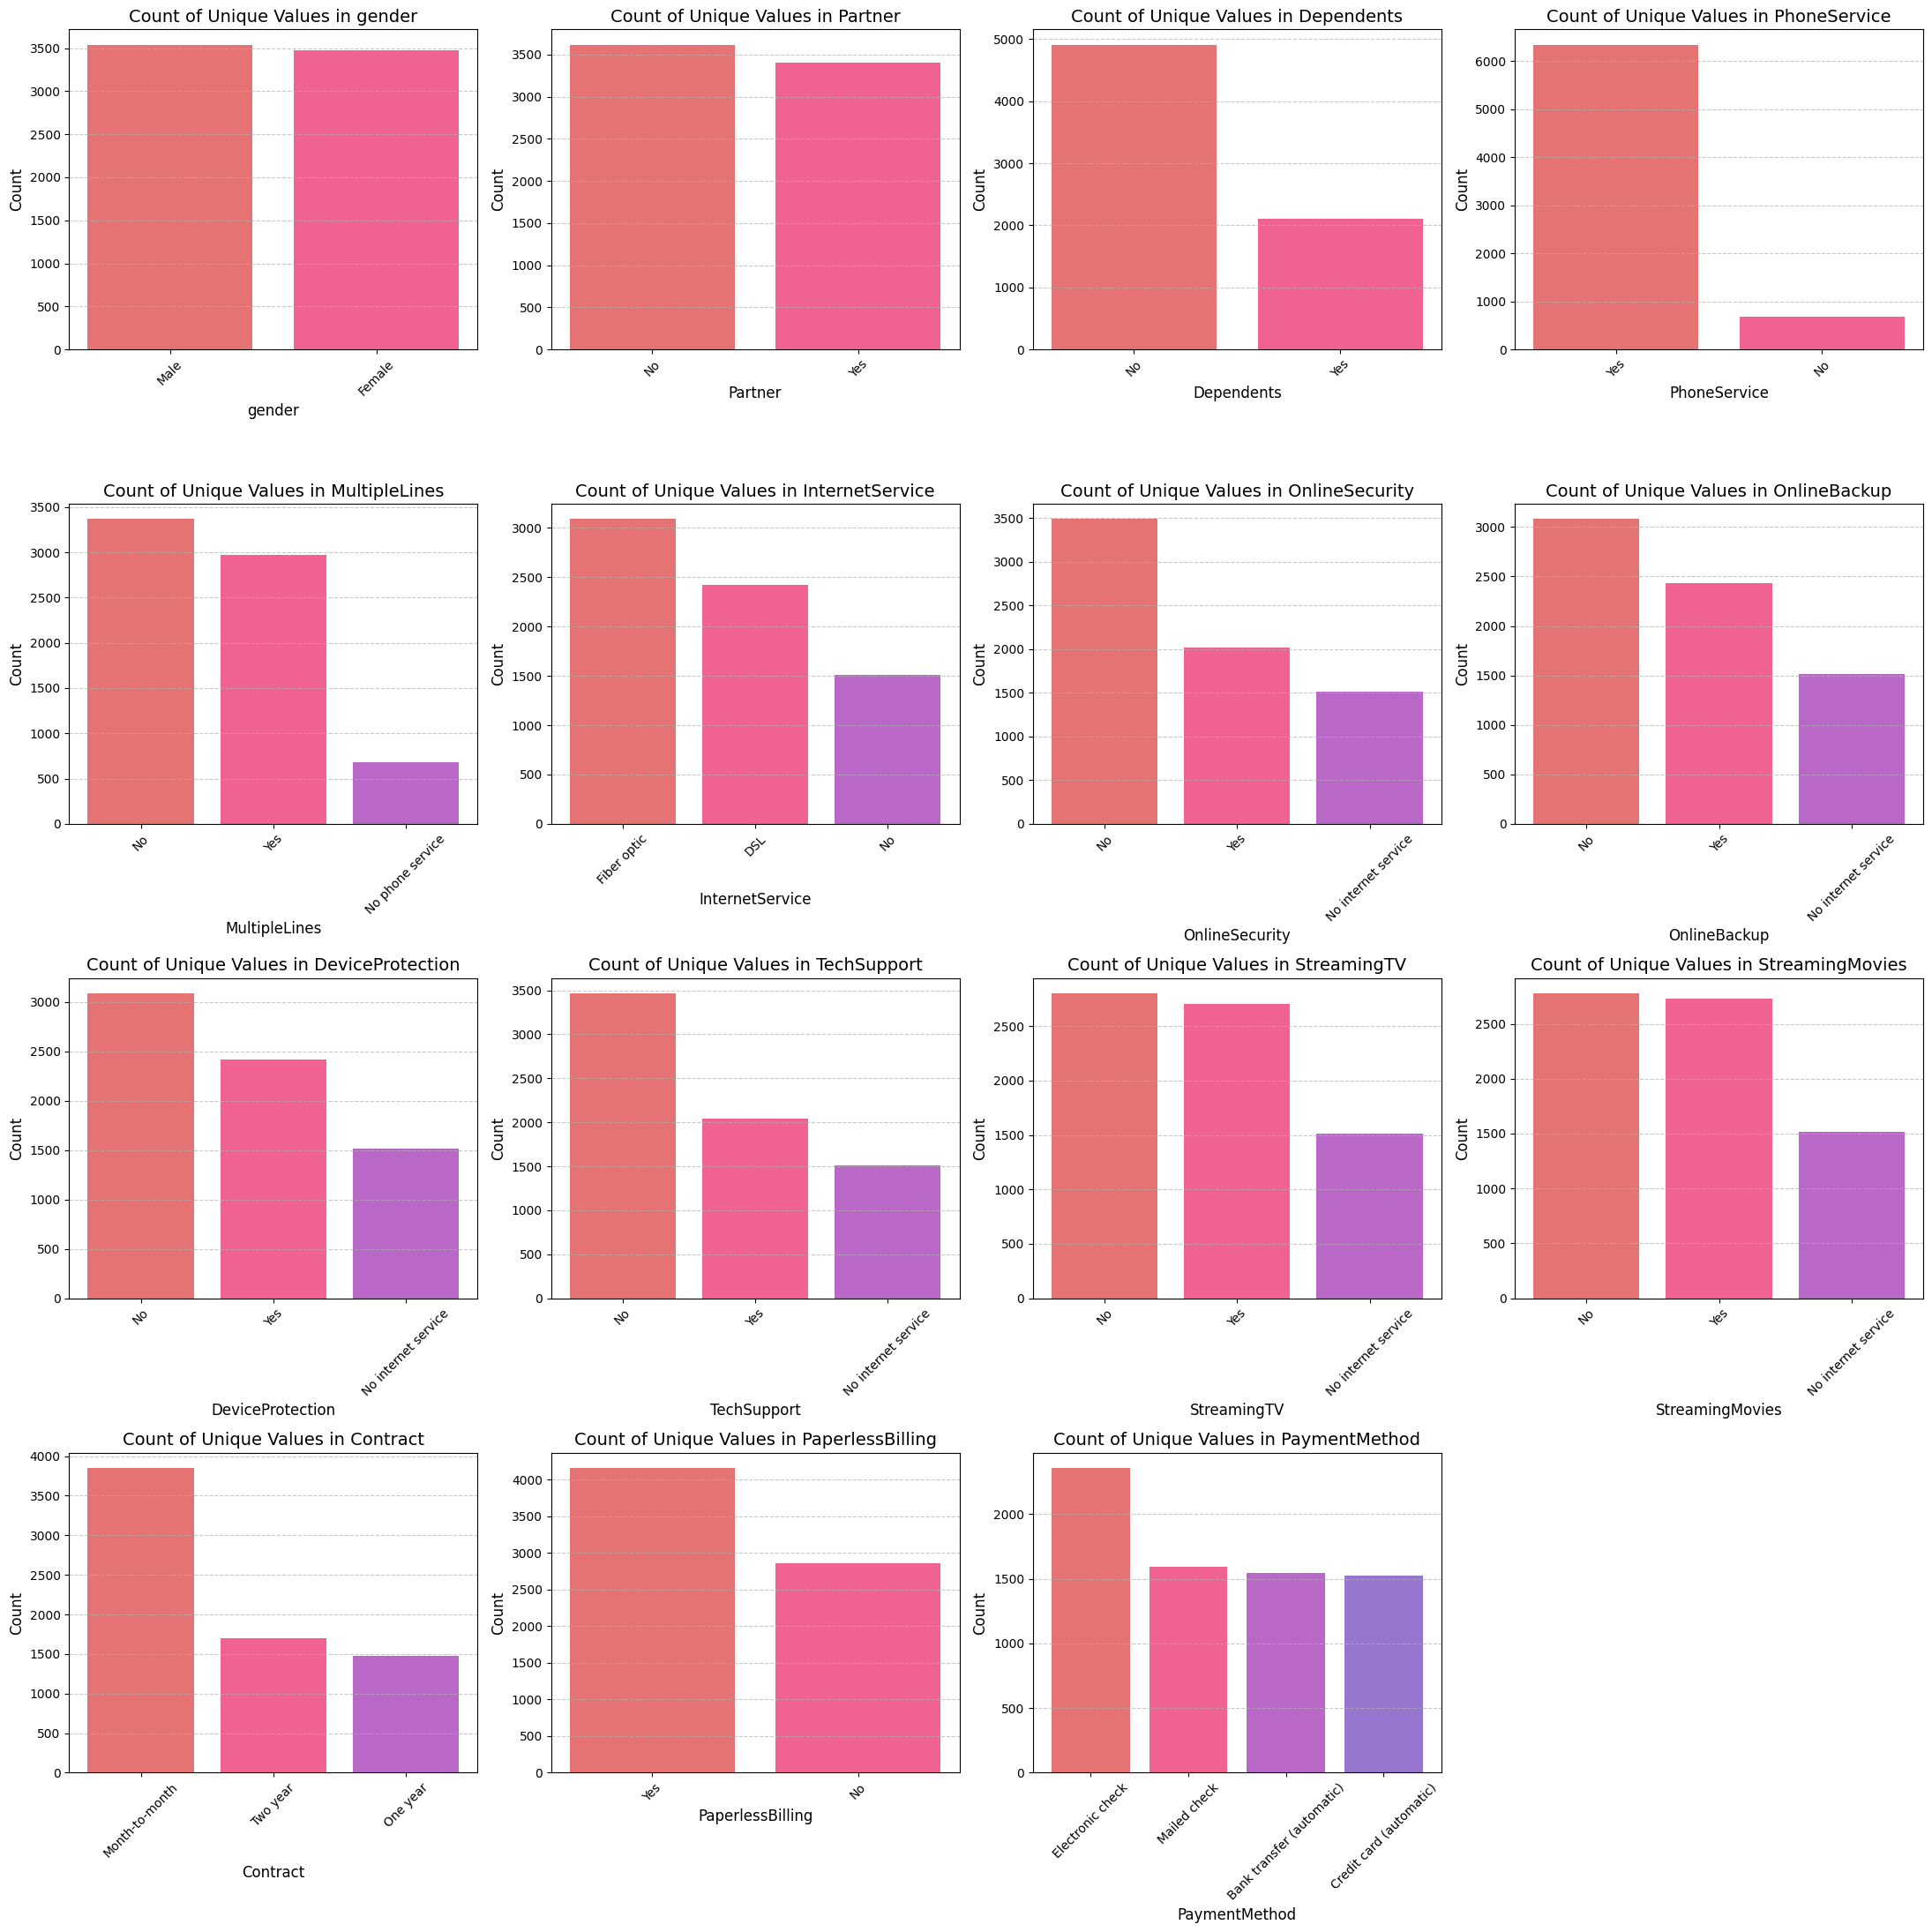

In [68]:
colors_12 = ['#E57373', '#F06292', '#BA68C8', '#9575CD', '#7986CB',
             '#4FC3F7', '#4DB6AC', '#81C784', '#AED581', '#FFB74D',
             '#FF8A65', '#A1887F']

def plot_categorical_counts_with_limited_colors(data, categorical_cols, plots_per_row=4):
    total_plots = len(categorical_cols)
    rows = math.ceil(total_plots / plots_per_row)  # Calculate required rows

    # Adjust figure size for better visibility
    fig, axes = plt.subplots(rows, plots_per_row, figsize=(22, 5.5 * rows))
    axes = axes.flatten()  # Flatten axes array for easy indexing

    for i, col in enumerate(categorical_cols):
        ax = axes[i]

        # Calculate value counts and ensure correct ordering
        counts = data[col].value_counts()
        categories = counts.index

        # Use the same 12 colors, cycling as needed
        bar_colors = colors_12 * (len(categories) // len(colors_12) + 1)

        # Plot count bar chart
        ax.bar(categories, counts, color=bar_colors[:len(categories)])

        # Use .replace("_str", "") to clean up the temporary SeniorCitizen column name
        ax.set_title(f'Count of Unique Values in {col.replace("_str", "")}', fontsize=14)
        ax.set_xlabel(col.replace("_str", ""), fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Remove empty subplots
    for j in range(total_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

cat_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()

cat_cols.remove('Churn')

# Plot count bar charts for all categorical columns
plot_categorical_counts_with_limited_colors(df_cleaned, cat_cols, plots_per_row=4)

Count Plots with Target Variable

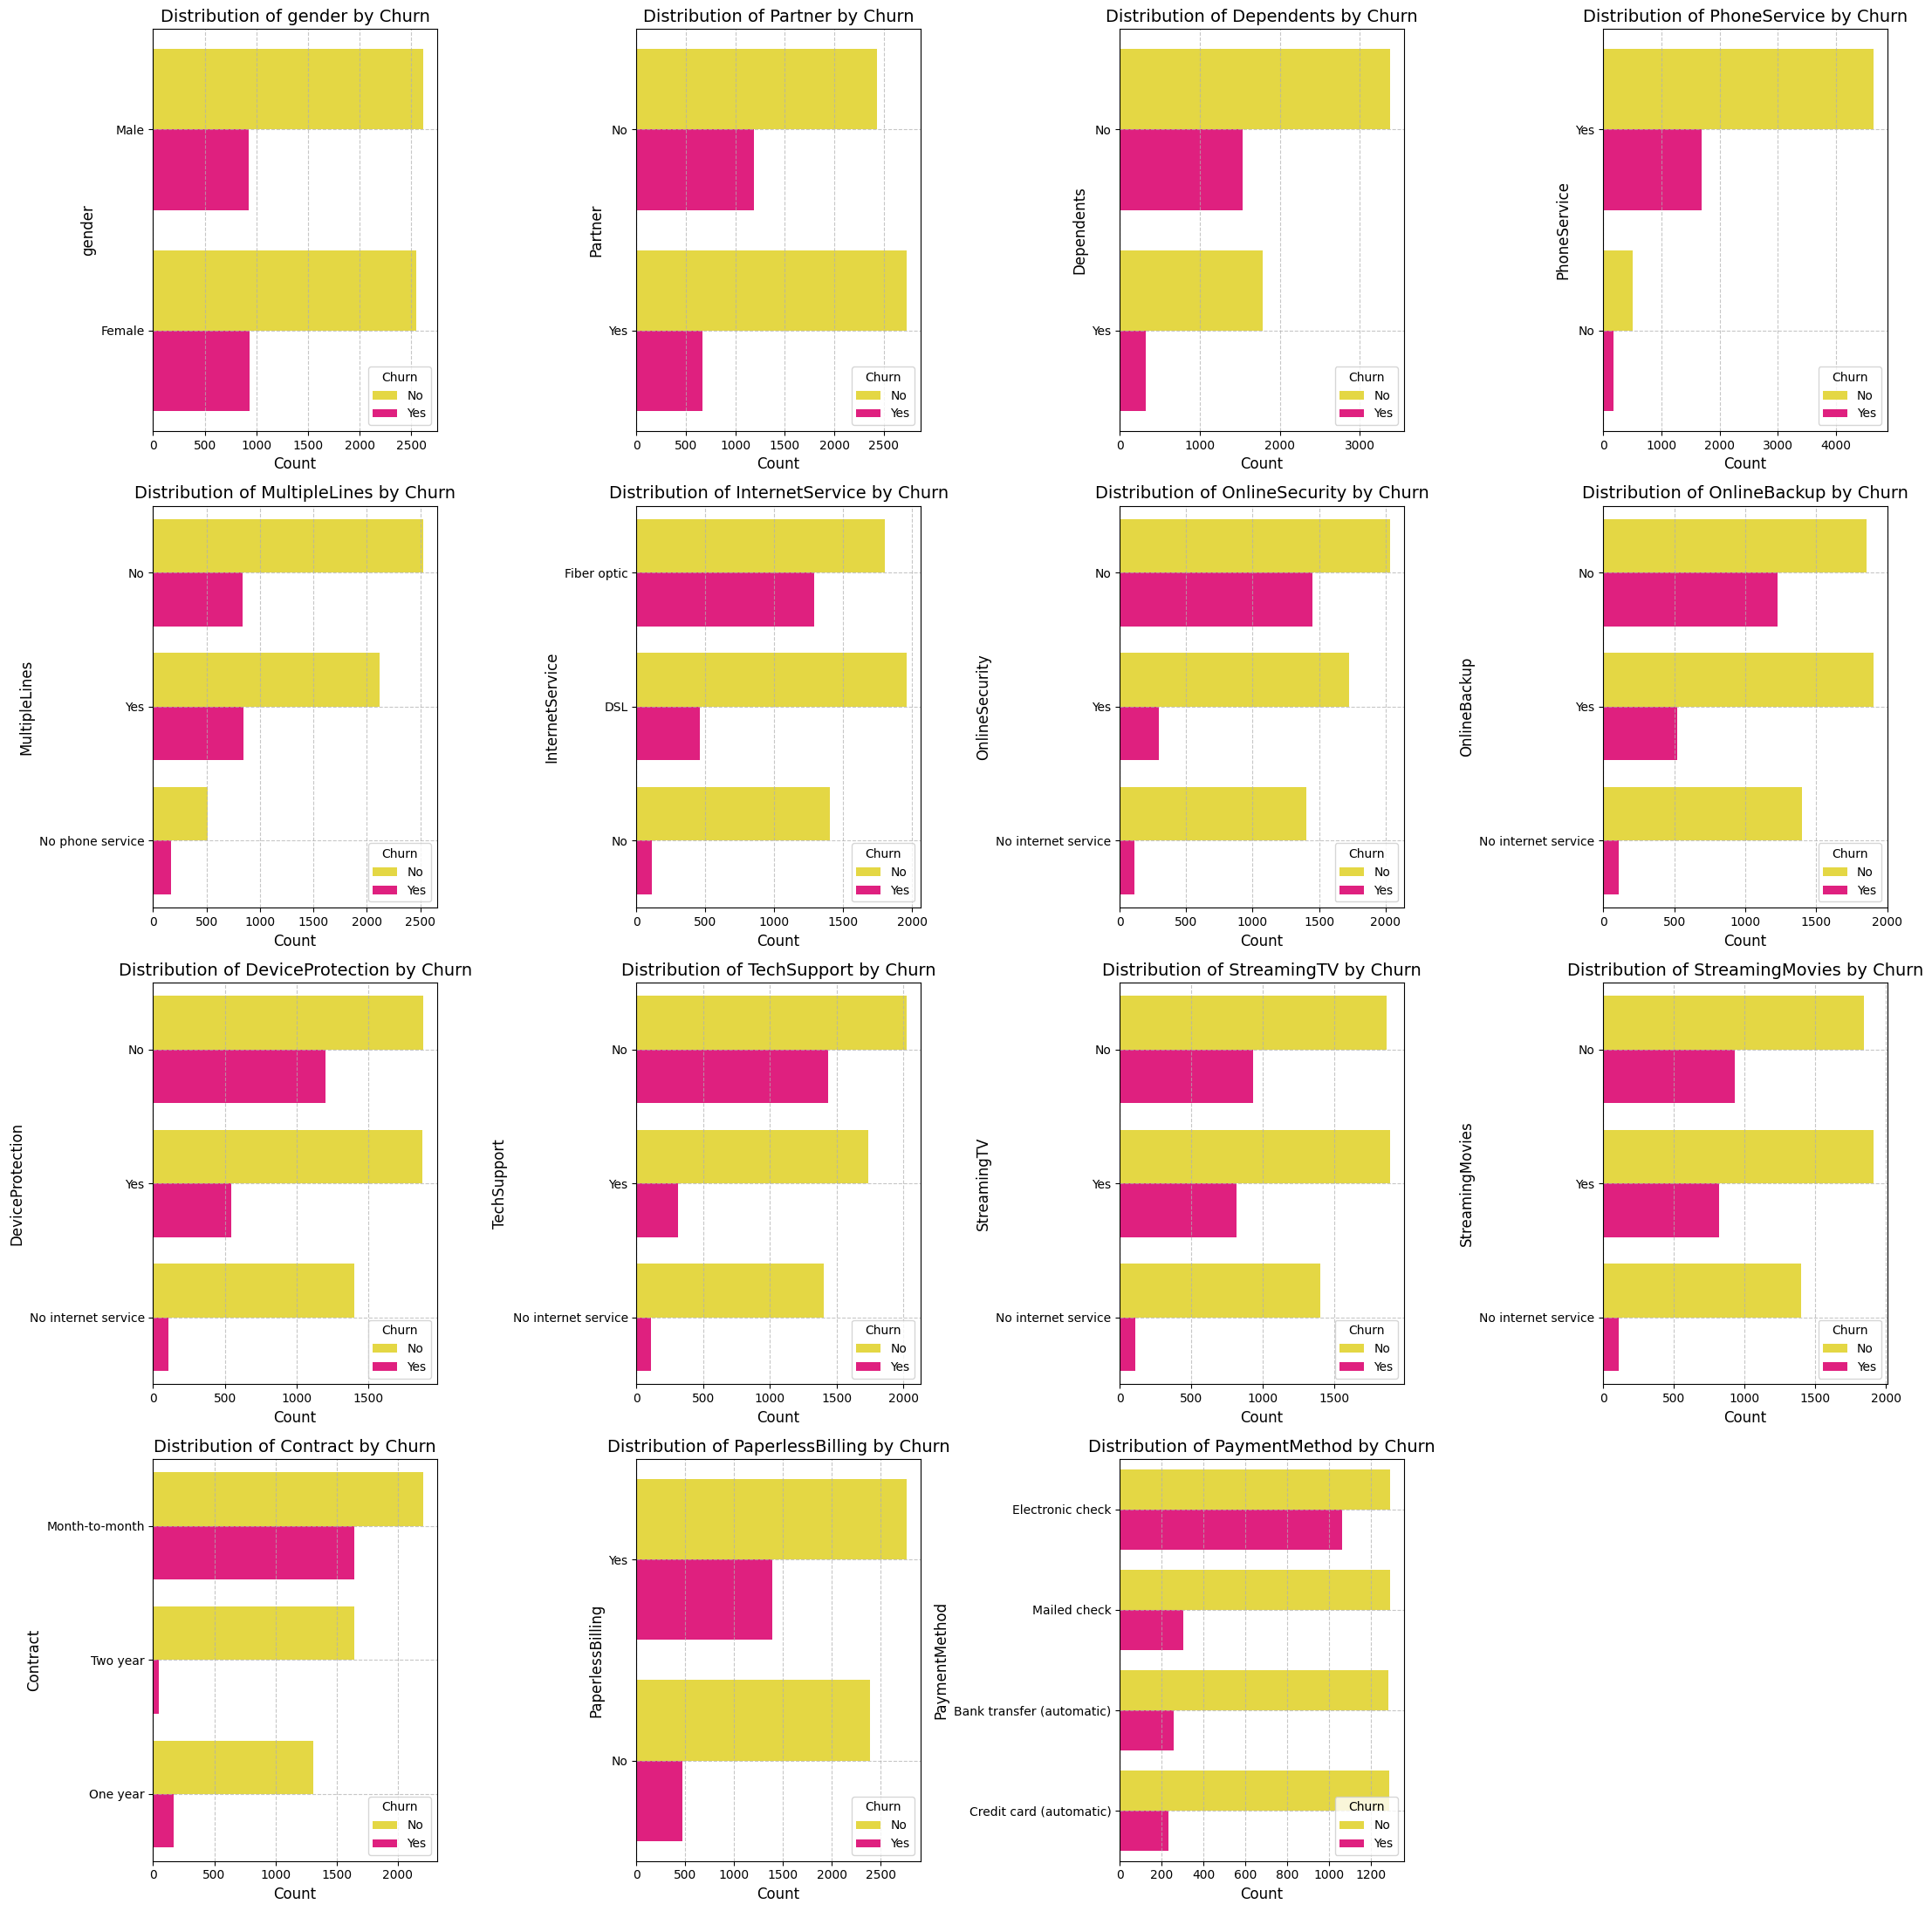

In [69]:

# Handle the TotalCharges issue (for data integrity)
df_cleaned['TotalCharges'] = pd.to_numeric(df_cleaned['TotalCharges'], errors='coerce')
df_cleaned['TotalCharges'] = df_cleaned['TotalCharges'].fillna(0)

churn_palette = {'Yes': '#ff007f', 'No': '#FFED29'} # Red for Churn, Blue for No Churn

# Function to plot count charts split by Churn
def plot_categorical_counts_by_churn(data, categorical_cols, plots_per_row=4):
    total_plots = len(categorical_cols)
    rows = math.ceil(total_plots / plots_per_row)

    # Adjust figure size for better visibility
    fig, axes = plt.subplots(rows, plots_per_row, figsize=(22, 5.5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        sns.countplot(data=data, y=col, hue='Churn', ax=ax, palette=churn_palette, order=data[col].value_counts().index)

        # Set plot titles and labels
        ax.set_title(f'Distribution of {col.replace("_str", "")} by Churn', fontsize=14)
        ax.set_ylabel(col.replace("_str", ""), fontsize=12)
        ax.set_xlabel('Count', fontsize=12)

        # Remove grid lines on the x-axis for cleaner count plot display
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Remove empty subplots
    for j in range(total_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

cat_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Churn')

# Plot count charts split by Churn
plot_categorical_counts_by_churn(df_cleaned, cat_cols, plots_per_row=4)